# Support Vector Machine

In this question, we consider an application of SVM as a classifier. The SVM classifier main idea is to separate the two classess (We will transform the data from $y_i \in \{0, 1\}$ to $y_i \in \{-1, 1\}$

## Let's  $\ell_2$ SVM - More Advance Perceptron (Soft Margin)

The ridged-SVM classification problem can be formulated as the following optimization problem:

$$\underset{w, b}{\text{min }} \frac{\lambda}{2}\left\|w\right\|_2^2 + \frac{1}{n}\sum_{i=1}^{N}{\left(1 - y_i\left(w^\top x_i +b\right)\right)_+}$$

where $y_i$ denotes the $i^{th}$ label, $x_i$ denotes the $i^{th}$ vector of features in the dataset, $w$ is the weights or vector of coefficients, $b$ is the bias term, and $\lambda$ is a model parameter is inversely related to the ridge regularization of the weights vector $w$. This is a quadratic optimization problem.

For this SVM, we are using a Linear Kernel, that explain the hyperplane that we are using on the Loss Function. Later we will play with this idea and introduce more interesting kernels, and introduce some non-linearities.

<!-- Using `cvxpy`, implement this SVM (estimate the $w$ and $b$ parameters) on the training set and tune the parameter $C$ from $0$ to $100$ by checking classification accuracy on the validation set. Plot the training accuracy versus $C$ curve and validation accuracy versus $C$ curve. Briefly comment on the results. -->

### Gradient Descent - Reprise

Let's compute the derivatives of the Loss function so we can use Gradient Descent as our method of solving for the weights of SVM. We have two terms on our Loss function, the regularized part and the sum of the errors with the hyperplane

$$
\frac{\partial}{\partial \omega} \frac{\lambda}{2}\left\|w\right\|_2^2 = \lambda \omega
$$

$$
\frac{\partial}{\partial \omega} {\left(1 - y_i\left(w^\top x_i+b\right)\right)_+}  = \left\{
        \begin{array}{ll}
            0 & \quad \text{if} \quad y_i\left(w^\top x_i+b\right) \geq 1 \\
            -y_ix_i , & \quad otherwise
        \end{array}
    \right.
$$

To understand the process of the gradient, it's divided into 2 parts: the Regularizer and the Hyperplane. When a sample $x_i$ it's correctly classified, we update the vector only by the regularizer, if the sample $x_i$ it's incorrectly misclassified, we update the weights with both the regularizer and the gradient of the plane. 

## Imports and Spark Session

In [1]:
# imports
import re
import time
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

from pyspark.ml.linalg      import Vectors
from pyspark.mllib.linalg   import SparseVector, DenseVector

from sklearn                import  metrics

In [2]:
%reload_ext autoreload
%autoreload 2

In [3]:
# store path to notebook
PWD = !pwd
PWD = PWD[0]

In [4]:
# start Spark Session
from pyspark.sql import SparkSession, SQLContext
app_name = "svm_toy"
master = "local[*]"
ss = SparkSession.builder\
     .config('spark.executor.memory',       '4G')\
     .config('spark.driver.memory',        '40G')\
     .config('spark.driver.maxResultSize', '10G')\
     .getOrCreate()
sc = ss.sparkContext
sq = SQLContext(sc)

## Data preparation

In [5]:
%%time
# Let's read the toy dataset. 
toy_data = ss.read.parquet('../data/train.parquet.toy')

# Transform Sparse Vectors to Dense Vectors and transform to Pandas
toy_data = toy_data.rdd.map(
    lambda x: (x[0], DenseVector(x[1].toArray()), x[2])).toDF(
        ["label", "features", "weights"]).toPandas()

# Let's replace 0 for -1 in the Label data, so we can use the perceptron
toy_data['label'] = toy_data['label'].replace(0,-1)
toy_data.head()

CPU times: user 1.11 s, sys: 101 ms, total: 1.21 s
Wall time: 9.63 s


,label,features,weights
0,-1,"[0.052855321300768685, -0.0051331139029484624,...",0.256196
1,1,"[0.052855321300768685, -0.007699670854422694, ...",0.743804
2,1,"[0.4756978917069181, 0.24895602429300043, 0.00...",0.743804
3,-1,"[0.052855321300768685, -0.010266227805896925, ...",0.256196
4,-1,"[0.052855321300768685, 0.012832784757371155, 0...",0.256196


In [6]:
# Transform our toy data set into a RDD, with the corresponding form (y, features_array)
# We map to a list to be able to use regular RDD commands. We use a helper function to parse the Dataframe
# I won't be using the weights factor yet
def parse(line):
    """
    Map records from Row --> (tuple,of,fields)
    """
    fields = np.array(line) #Will be added later , dtype = 'float')
    features,y = fields[1], fields[0]
    return(features, y)

toy_dataRDD = sq.createDataFrame(toy_data).rdd.map(parse).cache()

In [7]:
# Split 80/20 the data (pseudo)random train/test.
trainRDD, heldOutRDD = toy_dataRDD.randomSplit([0.8,0.2], seed = 1)
print(f"""... held out {heldOutRDD.count()} records for evaluation and assigned {trainRDD.count()} for training.""")

... held out 1649 records for evaluation and assigned 6351 for training.


## Gradient Descent Algorithm

### Baseline Model

In [8]:
# Mean of label
meanLabel = trainRDD.map(lambda x: x[1]).mean() 

# Baseline Model
BASELINE = np.append([meanLabel], np.zeros(len(trainRDD.take(1)[0][0])))

### Hinge Loss

In [5]:
# Function for the hinge loss
def HingeLoss(dataRDD, W):
    """
    Compute loss function for hinge: max of 0 or (1-y(WT*x))  
    (Note: W vector has bias term at 0 position)
    Args:
        dataRDD - each record is a tuple of (features_array, y)
        W       - (array) model coefficients with bias at index 0
    """
    augmentedData = dataRDD.map(lambda x: (np.append([1.0], x[0]), x[1]))
    # We will map the loss calculation to each observation, we calculate difference between the real value of the 
    # observation and the estimated value given by the weights
    loss = augmentedData.map(lambda x: (np.maximum(1-x[1]*(np.matmul(x[0],W)),0))).mean()
    return loss

### Gradient Descent Update

In [4]:
# SVM Update with Regularization
def SVM_GDupdate(dataRDD, W, lr = 0.1, regPar = 0.1, reg = 'l2', kernel = 'linear'):
    """
    Perform one gradient descent update, you can decide kernel or Type of regularization
    Args:
        dataRDD  - tuple of (features_array, y)
        W        - (array) model coefficients with bias at index 0
        lr       - (float) defaults to 0.1
        regPar   - (float) defaults to 0.1
        reg      - (str) Type of regularization used - defaults to L2, can go to L1
        kernel   - (str) type of kernel used, defaults to Linear
    Returns:
        model   - (array) updated coefficients, bias still at index 0
    """
    # First step, we broadcast the initial weights
    w = sc.broadcast(W)
    
    # Second, let's augment our data
    augmentedData = dataRDD.map(lambda x: (np.append([1.0], x[0]), x[1]))
    
    # Helper functions
    def l2_grad(line):
        """
        Helper function with the L2 gradient
        Args:
            w     - Array of old weights to be updated
            line  - Observation point tuple (feature_array, Y)
        Output:
            w_new - New weights
        """
        # From the tuple of observations, get the y and X
        y, X = line[1], line[0]
        
        # The gradient will depend on the misclassification of any given point
        if (y*np.dot(X,w.value)) < 1:
            grad =  -1*y*X
        else:
            grad = 0
            
        # Finally we yield the new total gradient
        yield (grad)
                
    # Let's add to each gradient its penalization, depending of the type of regression       
    if reg == 'l2':
        # Calculate the batch gradient
        grad = augmentedData.flatMap(l2_grad).mean()
        # We only regularized features weights
        w_nobias = np.append([0.0], W[1:])
        # We update the gradient including regularization
        grad += regPar*w_nobias
       
    # Update the Weights
    new_model = W-lr*grad
    
    return new_model

In [11]:
# Gradient Descent Algorithm
def SVM_GD(trainRDD, testRDD, wInit, nSteps = 20, LR = 0.1, regPar = 0.1, 
           regType = "l2", kernel = "linear", verbose = False):
    """
    Perform nSteps iterations of regularized gradient descent and 
    track loss on a train/test set. Return lists of
    train/test loss and the models themselves.
    """ 
    # Initialize lists to track model performance
    train_history, test_history, model_history = [], [], []
    
    # Perform n updates & compute test and train loss after each
    model = wInit
    m = sc.broadcast(model)
    
    for idx in range(nSteps):  
        # update the model 
        model = SVM_GDupdate(trainRDD, m.value, LR, regPar, regType, kernel)
        m = sc.broadcast(model)
        
        # keep track of test/train loss for plotting
        train_history.append(HingeLoss(trainRDD, m.value))
        test_history.append(HingeLoss(testRDD, m.value))
        model_history.append(model)
        
        # console output if desired
        if verbose:
            print("----------")
            print(f"STEP: {idx+1}")
            print(f"training loss: {train_history}")
            print(f"test loss: {test_history}")
            print(f"Model: {[round(w,3) for w in model]}")
    return train_history, test_history, model_history

### Train using Gradient Descent

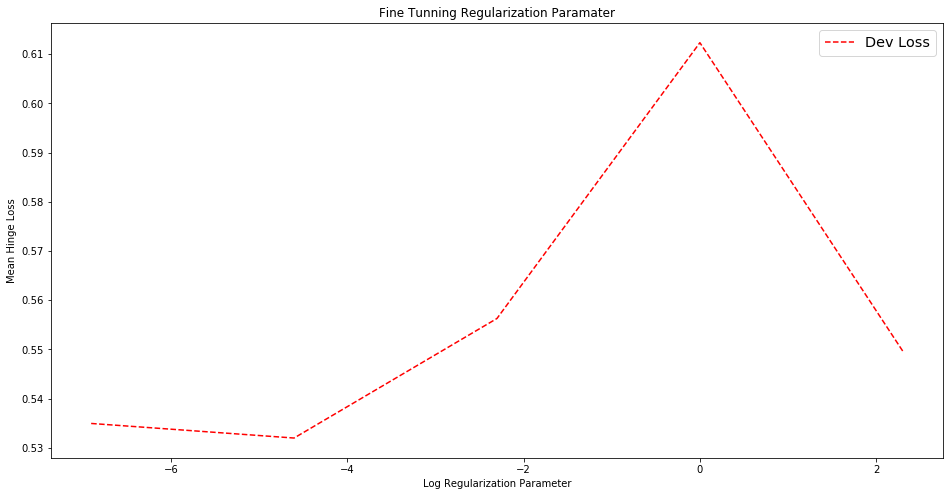

In [22]:
# Tune the Regularization Parameter
wInit = BASELINE
reg_par = [0.001, 0.01, 0.1, 1, 10]
dev_loss = []
j = 0
for i in reg_par:
    svml2_results = SVM_GD(trainRDD, heldOutRDD, wInit, nSteps = 50, LR = 0.1, 
                                     regType='l2', regPar = i, kernel = "linear", verbose=False)
    _, test_loss, _ = svml2_results
    dev_loss.append(test_loss[-1])

# Graph it
fig, ax = plt.subplots(1,1,figsize = (16,8))
ax.plot(np.log(reg_par), dev_loss, 'r--', label='Dev Loss')
ax.legend(loc='upper right', fontsize='x-large')
plt.xlabel('Log Regularization Parameter')
plt.ylabel('Mean Hinge Loss')
plt.title("Fine Tunning Regularization Paramater")
plt.show()

To minimize the loss on the Development set, the best Regularization Parameter seems to be 0.01. For the final model, we will train it using this value

In [23]:
# Final Train
start = time.time()
svml2_results = SVM_GD(trainRDD, heldOutRDD, wInit, nSteps = 1000, LR = 0.1, 
                                     regType='l2', regPar = 0.01, kernel = "linear", verbose=False)
print(f"\n... trained {len(svml2_results[2])} iterations in {time.time() - start} seconds")

# Save Model
trainLoss, testLoss, models = svml2_results
np.savetxt(PWD + '/data/svml2_models.csv', np.array(models), delimiter=',')
np.savetxt(PWD + '/data/svml2_loss.csv', np.array([trainLoss, testLoss]), delimiter=',')


... trained 1000 iterations in 889.1155121326447 seconds


In [12]:
# Save the best model
svml2_models = np.loadtxt(PWD + '/data/svml2_models.csv', dtype=float, delimiter=',')
best_svml2 = svml2_models[-1,:]

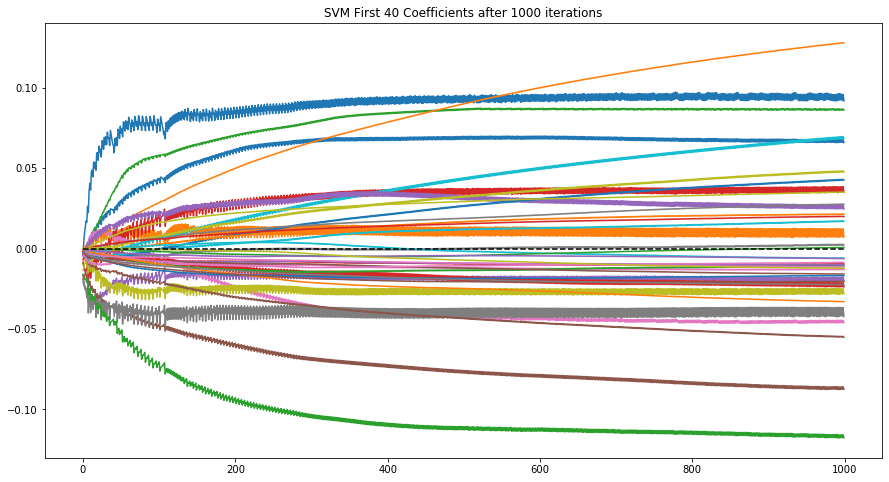

In [67]:
def plotCoeffs(models, title):
    """
    Helper Function to show how coefficients change as we train.
    """
    fig, ax = plt.subplots(figsize = (15,8))
    X = list(range(len(models)))
    for data in models.T[1:]:
        ax.plot(X, data)
    ax.plot(X,[0]*len(X), 'k--')
    plt.title(title)
    plt.show

plotCoeffs(svml2_models[:,0:40], "SVM First 40 Coefficients after 1000 iterations") 

### Test the model

In [13]:
# Let's read the toy test dataset. Note this is different from the set used above for training.
# Performing the same transformations
toy_data_test = ss.read.parquet('../data/tests.parquet.toy')

# Transform Sparse Vectors to Dense Vectors and transform to Pandas
toy_data_test = toy_data_test.rdd.map(
    lambda x: (x[0], DenseVector(x[1].toArray()), x[2])).toDF(
        ["label", "features", "weights"]).toPandas()

# Let's replace 0 for -1 in the Label data, so we can use the perceptron
toy_data_test['label'] = toy_data_test['label'].replace(0,-1)

# Transform into RDD
toy_data_testRDD = sq.createDataFrame(toy_data_test).rdd.map(parse).cache()

In [14]:
# Classification comes from the sign of the the classifier
def predict_svm(testRDD, W):
    """
    Perform prediction on test set
    Arg:
        testRDD:      RDD of (vector_features, y)
        W:            array of the best model after GD
    Output:
        y_predict:    array of predictions
    """  
    # First step, we broadcast the initial weights
    w = sc.broadcast(W)
    
    # Second, let's augment our data
    augmentedData = testRDD.map(lambda x: (np.append([1.0], x[0]), x[1]))
    
    # Helper functions
    def pred_line(line):
        """
        Helper function for producing the prediction
            line  - Observation point tuple (feature_array, Y)
        """
        # From the tuple of observations, get the y and X
        y, X = line[1], line[0]
        
        # Predict the class
        y_predict = np.sign(np.dot(X, w.value))
            
        # Finally we yield the prediction
        yield (y_predict)
        
    # Predict
    y_predict = augmentedData.flatMap(pred_line).cache()
    
    return y_predict

# Save the prediction and the real values
y_predict = np.array(predict_svm(toy_data_testRDD, best_svml2).collect())
y = np.array(toy_data_testRDD.map(lambda x: x[1]).collect())

# Calculate AUC
print(np.round(metrics.roc_auc_score(y, y_predict),6)*100, "%")

50.0 %


## Comparison with MLLib Packages

In [19]:
%%time
from pyspark.mllib.classification import SVMWithSGD, SVMModel
from pyspark.mllib.regression import LabeledPoint

# Load and parse the data
def parsePoint(line):
    y, X = line[1], line[0]
    if y==-1:
        y=0
    return LabeledPoint(y, X)

parsedData = trainRDD.map(lambda x: (np.append([1.0], x[0]), x[1])).map(parsePoint)

# Build the model
model = SVMWithSGD.train(parsedData, iterations=1000, intercept=True, regParam=0.01)
model.save(sc, PWD + '/data/svml2_model_mllib')

CPU times: user 2.41 s, sys: 1.71 s, total: 4.11 s
Wall time: 3min 29s


In [17]:
# Test and AUC
parsedTest = toy_data_testRDD.map(lambda x: (np.append([1.0], x[0]), x[1])).map(parsePoint)
y_predict_mllib = parsedTest.map(lambda p: (model.predict(p.features))).collect()
print(np.round(metrics.roc_auc_score(y, y_predict_mllib),6)*100, "%")

50.0 %


In [46]:
# Bias Term
print("Homegrown Bias is %0.4f"%best_svml2[0])
print("MLLib bias is %0.4f"%(model.intercept-1))

Homegrown Bias is -0.7282
MLLib bias is -0.8550


| Metric | Kombucha Gradient Descent | MLLib Stochastic Gradient Descent|
|-----------------|:-----------------------:|:-------------------------:|
| Time | 14min 49 s | 3min 29s|
| AUC | 50\% | 50\%|
| Bias | -0.7282 | -0.8550 |
| Complexity | $O(nClog(1/\epsilon)$|  $O(C/\epsilon)$ 

In [24]:
data = ss.read.parquet('../data/train.parquet.normed.masked-060000.encode.picked-000987.packed-001000')
test = ss.read.parquet('../data/tests.parquet.normed.masked-060000.encode.picked-000987.packed-001000')

# Transform Sparse Vectors to Dense Vectors and transform to Pandas
data = data.rdd.map(
    lambda x: (x[0], DenseVector(x[1].toArray()), x[2])).toDF(
        ["label", "features", "weights"])

test = test.rdd.map(
    lambda x: (x[0], DenseVector(x[1].toArray()), x[2])).toDF(
        ["label", "features", "weights"])

In [25]:
def parse(line):
    """
    Map records from Row --> (tuple,of,fields)
    """
    fields = np.array(line)
    features,y = fields[1], fields[0]
    if y==-0:
        y=-1
    return(features, y)

dataRDD = data.rdd.map(parse).cache()
testRDD = test.rdd.map(parse).cache()

In [ ]:
# Mean of label
meanLabel = dataRDD.map(lambda x: x[1]).mean() 

# Baseline Model
BASELINE = np.append([meanLabel], np.zeros(len(dataRDD.take(1)[0][0])))
wInit = BASELINE

# Final Train
start = time.time()
svml2_results = SVM_GD(dataRDD, testRDD, wInit, nSteps = 10, LR = 0.1, 
                                     regType='l2', regPar = 0.01, kernel = "linear", verbose=False)
print(f"\n... trained {len(svml2_results[2])} iterations in {time.time() - start} seconds")

# Save Model
trainLoss, testLoss, models = svml2_results
np.savetxt(PWD + '/data/svml2_models_big.csv', np.array(models), delimiter=',')
np.savetxt(PWD + '/data/svml2_loss_big.csv', np.array([trainLoss, testLoss]), delimiter=',')